In [6]:
import pandas as pd
import numpy as np

import operator as op
import re

#Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# Custom Transformers
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector



import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv("../data/listings.csv", sep = ",")

latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'

In [9]:
def print_boxplot(df):
    fig, ax = plt.subplots(nrows = 10, ncols = 3, figsize=(15,30))
    fig.subplots_adjust(hspace=0.5)
    
    df_numerical = ["accommodates", "bathrooms", "bedrooms", "beds", "minimum_nights_avg_ntm", 'availability_60', 'availability_90', 'availability_365',
                   "review_scores_location", "reviews_per_month", "number_of_reviews_ltm", "reviews_per_month"]

    line = 0
    col = 0
    index = [0,0]
    for feat in df_numerical:        
        #Plot boxplot of current feature
        sns.boxplot(data = df,x = feat, ax = ax[line, col])

        #Update index for plotting for the next iteration
        if(col + 1 == 3):
            col = 0
            line += 1
        else:
            col +=1

In [10]:
class ColumnDroppersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def transform(self, X, y=None):
        
        print("Start - ColumnDroppersTransformer")
        
        # Find features related to host, id and url
        re_drop = ".*host.*|.*id.*|.*url.*"
        drop_feat = []
        for feat in X.columns:
            if re.match(re_drop, feat):
                 drop_feat.append(feat)
        # Add extra features that for sure will not ber part of the model
        drop_feat.extend(["calendar_updated", "license", "neighbourhood_group_cleansed","neighbourhood_cleansed", "neighbourhood", "neighborhood_overview", 
                          "last_scraped", "source", "first_review", "last_review", "name", "number_of_reviews_l30d", "number_of_reviews",
                          "availability_30", "minimum_nights", "maximum_nights", "review_scores_value",  
                         "review_scores_accuracy", "review_scores_rating", "review_scores_checkin", "review_scores_cleanliness", "review_scores_communication",
                         "has_availability", "instant_bookable", "calendar_last_scraped", 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
                          'maximum_maximum_nights', 'maximum_nights_avg_ntm', 'property_type', 'description'])
        
        X = X.drop(drop_feat, axis = 1)
        
        print("End - ColumnDroppersTransformer")
        
        print(X.columns)
    
        print_boxplot(X)
    
    
        return X
    
    def fit(self, X, y=None):
        return self
    
class DropNasTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def transform(self, X, y=None):
        
        print("Start - DropNasTransformer")
        
        
        X = X.dropna(subset = self.features)
        
        print(type(X))
        print("End - DropNasTransformer")
        
        
        return X
    
    def fit(self, X):
        
        
        return self
    
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, features_limit, mode = "remove", operator = "eq"): #st: smaller then
                    
        self.opt_dict = {
        "lt":op.lt,
        "le":op.le,
        "eq":op.eq,
        "ne":op.ne,
        "ge":op.ge,
        "gt":op.gt,
        }    
        
        self.features_limit = features_limit # list of tuples
        self.mode = mode  #mode of operation (cap value or remove value)
        self.operator = operator #lt, eq, gt, ...
     
    
    def transform(self, X, y=None):
        
        print("Start - OutlierRemover")

        
        
        NAME = 0
        LIMIT = 1
        REPLACE_VALUE = 2
        for a_feature in self.features_limit:
            if(self.mode == "remove"): ###!!! check if it works
                X = X.drop(X[self.opt_dict[self.operator](X[a_feature[NAME]], a_feature[LIMIT])].index, axis = 0)
            elif(self.mode == "cap"):
                X[a_feature[NAME]] =  X[a_feature[NAME]].apply(lambda x : x if self.opt_dict[self.operator](x,a_feature[LIMIT]) else a_feature[LIMIT])
            elif(self.mode == "replace"):
                X[a_feature[NAME]] =  X[a_feature[NAME]].apply(lambda x : a_feature[REPLACE_VALUE] if self.opt_dict[self.operator](x,a_feature[LIMIT]) else x)
        

        #print(X.room_type.unique())
        #input()
        
        print("End - OutlierRemover")
        
        
        return X
    
    def fit(self, X):
        return self
        
        
class ClusterGeolocationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, clusters = 8, init = 'k-means++', n_init = 'auto', max_iter = 300):
        
        self.clusters = clusters
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
    
    def transform(self, X, y=None):
        
        print("Start - ClusterGeolocationTransformer")
        
        # Initialize the model
        k_means = KMeans(
            init = self.init,
            n_clusters = self.clusters,
            n_init = self.n_init,
            max_iter = self.max_iter,
            random_state = 69
        )


        #Select the data to be clustered
        df_kmeans = X.loc[:,["latitude", "longitude"]]

        # Fitting
        k_means.fit(df_kmeans)

        #Clusters as a feature
        X['geo_cluster'] = k_means.labels_ 
        #X['geo_cluster'] = X['geo_cluster'].astype("str") # Probably not needed (!) - checkc

        ## Encode here
        
        onehot_encoder_cluster = OneHotEncoder(sparse_output = False, feature_name_combiner='concat')
        series_cluster_onehot = onehot_encoder_cluster.fit_transform(X[["geo_cluster"]])
        encoded_cat_str = [str(x) for x in onehot_encoder_cluster.categories_[0]]
        X[encoded_cat_str] = series_cluster_onehot
        X = X.drop("geo_cluster", axis = 1)
    
        
        #Drop latitude and longitude as they will not be fed into the model
        X = X.drop(["longitude", "latitude"], axis = 1)
        
        
        print("End - ClusterGeolocationTransformer")
        
        return X
    
    def fit(self, X):
        return self



class PreprocessCorpus(BaseEstimator, TransformerMixin):
    def __init__(self, corpus_feature):
        self.corpus_feature = corpus_feature

    
    def transform(self, X, y=None):
        
        print("Start - PreprocessCorpus")
        
        
        def process_corpus(corpus):
            
            corpus = corpus.lower()
            corpus = re.sub(r'[^a-zA-Z ]', ' ', corpus)
            corpus = re.sub(r'\b(the|and|in|with|to|a|of|br|is|from|for|on|this|you|it|has|all|at|de|by|br)\b', ' ', corpus)
            corpus = re.sub(r'br\b', '', corpus)
            return corpus
    
        X[self.corpus_feature] = X[self.corpus_feature].apply(lambda x : process_corpus(x))
        
        print("End - PreprocessCorpus")
        
        return X
    
    def fit(self, X):
        return self    


class ContainWordsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, words, new_feature_name, corpus_target):
        self.words = words
        self.new_feature_name = new_feature_name
        self.corpus_target = corpus_target
    

    def fit(self, X):
        return self

    def transform(self, X, y=None):
        
        print("Start - ContainWordsTransformer")
        
        
        
        def check_lux_corpus(x):
            
            # Transform list of words in regex
            words_str = ""
            for i in self.words:
                words_str = words_str + i + "|"
            #remove last "|"
            words_str =  words_str[:-1] 
            regex = r'\b('+words_str+r')\b'
            
            
            # Return if description contains lux word or not
            if (re.search(regex, x)):
                return 1
            else:
                return 0
        
        #Create the feature that identify a property as luxurious
        X[self.new_feature_name] = X[self.corpus_target].apply(check_lux_corpus)
    
        
        # Drop corpus target feature
        #X = X.drop(self.corpus_target, axis = 1)
        
        print("End - ContainWordsTransformer")
        
        return X
    
    
class ExtractAmenitiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, amenities_dict):
        self.amenities_dict = amenities_dict
    
    def transform(self, X, y=None):
        
        print("Start - ExtractAmenitiesTransformer")
        
        #This function will check the presence of the amenities in the list using regex
        def convert_amenities(amenities, index): 
            for amn_name, amn_re in self.amenities_dict.items():
                if(isinstance(amn_re,list)):
                    # Check each reg from the list of reg for an specific amenity. Ex ("seaview" : [".*beach view.*",".*sea view.*",".*ocean view.*"])
                    for reg in amn_re:
                        if(re.match(reg, str.lower(amenities))):
                            X.loc[index, "has_"+ amn_name] = 1
                else:
                    if(re.match(amn_re, str.lower(amenities))):
                        X.loc[index,"has_"+ amn_name] = 1
        
        # 1) Create and initalize the features from the amenities list
        has_amn_feat = ["has_" + x for x in self.amenities_dict.keys()]
        X[has_amn_feat] = 0
        
        # 2) For each amenities' list, check if they contain the amenities target
        for index, row in X.iterrows():
            convert_amenities(X.loc[index, "amenities"], index)
        
        # 3) Drop 'amenities' feature
        X = X.drop("amenities", axis = 1)
        
        print("End - ExtractAmenitiesTransformer")

        return X
    
    def fit(self, X):
        return self
    
    
   
    
class ExtractBathroom(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def transform(self, X, y=None):

        print("Start - ExtractBathroom")
        
        def bathroom_number(a_bath):
            
            is_shared = 0 #default value

            # Case if it is a missing value
            if(pd.isna(a_bath)):
                number_bath = np.nan
                is_shared = np.nan
                
            # Check if bathroom is shared using regex
            else:
                if(re.match(".*shared.*", str.lower(a_bath))):
                        is_shared = 1  

                        
            return is_shared
            
    

        X[["is_bathroom_shared"]] = X["bathrooms_text"].apply(lambda x: pd.Series(bathroom_number(x)))
        
        X = X.drop("bathrooms_text", axis = 1)
        
        print("End - ExtractBathroom")
        print(X.shape)
        
        return X
    
    def fit(self, X):
        return self
    

class CatImputer(BaseEstimator, TransformerMixin):
    def __init__(self, features_limits):
        self.features_limits = features_limits
    
    def transform(self, X, y=None):
        
        print("Start - CatImputer")
        
        FILL_VALUE = 1
        FEATURE = 0
        X_imp = X
        for feat in self.features_limits:
            imp = SimpleImputer(strategy='constant', fill_value= feat[FILL_VALUE])
            X_imp = imp.fit_transform(X_imp)
        
        print("End - CatImputer")
        
        return pd.DataFrame(X_imp, columns = X.columns)
    
    def fit(self, X):
        return self  
    

class NumImputer(BaseEstimator, TransformerMixin):
    def __init__(self, value):
        self.value = value
    
    def transform(self, X, y=None):
        
        print("Start - FeaturesImputer")
        
        num_ft = X.select_dtypes(exclude = 'object').columns
        for a_ft in num_ft:
            X.loc[:, a_ft] = X[a_ft].fillna(0)
        
        print("End - FeaturesImputer")
        
        
        
        return X
    
    def fit(self, X):
        
        
        return self
    
class ColumnTransformerDF(BaseEstimator, TransformerMixin):
    def __init__(self, transformers):
        self.transformers = transformers
        self.ct = None
        self.feature_names = None
    
    def fit(self, X):
        #Retain the feature name and order
        self.ct = ColumnTransformer(self.transformers)
        self.ct.fit(X) 
        self.feature_names = self.ct.get_feature_names_out()
        
        return self  
    
    def transform(self, X):
        
        X_ct = ct.transform(X)
        return pd.DataFrame(X_ct, columns = self.feature_names)
    
    
    
class TypeConversionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_to_type_list):
        self.feature_to_type_list = feature_to_type_list
    
    def transform(self, X, y=None):
    
        
        print("Start - TypeConversionTransformer")
        
        for feature, new_type in self.feature_to_type_list:
            X.loc[:,feature] = X[feature].astype(new_type)
        
        
        print("End - TypeConversionTransformer")
        
    
        
        return X
    
    def fit(self, X):
        
        
        return self
    
    
class FeatureEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, features_list):
        self.features_list = features_list
    
    def transform(self, X, y=None):
    
        
        print("Start - FeatureEncoding")
        
        for feature in self.features_list:    
            ## Encode here

            onehote_encoder = OneHotEncoder(sparse_output = False, feature_name_combiner='concat')
            series_onehot = onehote_encoder.fit_transform(X[[feature]])
            encoded_str = [str(x) for x in onehote_encoder.categories_[0]]
            X[encoded_str] = series_onehot
            X = X.drop(feature, axis = 1)
        
        print("End - FeatureEncoding")
        
        #print(X.columns)
        #print(X.shape)
        #input()
        
    
        return X
    
    def fit(self, X):
        
        
        return self

In [11]:
target_feature = "price"

###########################
# PREPROCESSING TARGET FT #
###########################

# Dropping 'na' for prices
df = df.dropna(subset = "price")

# Convert prices to numerical value
df["price"] = df["price"].apply(lambda x: float(x[1:].replace(",","")) if pd.notna(x) else x)

PRICE_CAP = 850
# Cap price outliers
df["price"] = df["price"].apply(lambda x : x if x < PRICE_CAP else PRICE_CAP)


# Drop prices that are zero
df = df.loc[df.price > 0, :]

########################
# PIPELINE PREPARATION #
########################

# Separte target feature from the dataset
X = df.drop(target_feature, axis = 1)
y = df[target_feature]


#############
# PIPELINE  #
#############


num_feat_extraction_pipeline = Pipeline([
    ("clusterlocation", ClusterGeolocationTransformer(clusters = 25, init = "random", n_init = 15, max_iter = 1000)),
    
       
    # binary is_score_empty (?) - maybe info is reduntant
])

##################################
##################################

cat_feat_extraction_pipeline = Pipeline([
    #Removes capital letters, ponctuation, etc...
    ("preprocesstext", PreprocessCorpus("description")),
     #Creates a new feature based on lux words
    ("extractluxdescription", ContainWordsTransformer(new_feature_name = "contains_lux_description", 
                                               corpus_target = "description",
                                               words = ["lux","luxurious","luxury","fancy","garage", 
                                                  "hydromassage", "cellar", "sophistication", 
                                                  "magnificent", "colonial", "rooftop", "triplex", "suite"])), 
    ("extractownerinhouse", ContainWordsTransformer(new_feature_name = "contains_simple_description", 
                                               corpus_target = "description",
                                               words = ["simple", "comfortable", "simplicity"])), 
    ("extractamenities", ExtractAmenitiesTransformer(
                                                { "parking": ".*parking on premises.*",
                                                  "pool":".*pool.*(?!.*\btable\b).*",
                                                  "washer": ".*washer.*",
                                                  "dishwasher": ".*dishwasher.*",
                                                 "ceiling_fan" : ".*ceiling fan.*",
                                                 "long_term" : ".*long term.*",
                                                 "bbq_grill" : ".*bbq grill.*",
                                                 "outdoor": ".*outdoor.*",
                                                 "hot_tub": ".*hot tub.*",
                                                 "bathtub": ".*bathtub.*",
                                                 "ac": [".*air conditioning.*","\\bac\\b"],
                                                 "seaview" : [".*beach view.*",".*sea view.*",".*ocean view.*"]
                                                }
    )),
    
    ("extractbathroom", ExtractBathroom()),
    
])

##################################
##################################

num_pipeline = Pipeline([
    ("num_imputer", NumImputer(value = 0)),
    ("outliers", OutlierRemover(
                                features_limit = [
                                                 ("minimum_nights_avg_ntm", 7),
                                                 ("beds", 8),
                                                 ("bedrooms", 5),
                                                 ("bathrooms", 5),
                                                 ("accommodates", 10),
                                                 ("number_of_reviews_ltm", 25),
                                                 ("reviews_per_month", 4),
                                                ],
                                mode = "cap",
                                operator = "lt" #operation: less then (lt)
                                
                                )),
    
])

##################################
##################################

cat_pipeline = Pipeline([
    ("cat_imputer", CatImputer(
                            features_limits = [("bathroom_text", "Private bath"),
                                               ("description", ""),
                                              ]
    )),
    ("outliers", OutlierRemover(
                                features_limit = [("room_type", "Hotel room", "Private room")], #Replace 'Hotel room' by 'Private room'
                                mode = "replace",
                                operator = "eq",
    )),

])

##################################
##################################


preprocessor_pipeline = Pipeline([   
      
    #Imputers
    ("num_imputer", NumImputer(value = 0)),
    ("cat_imputer", CatImputer(
                            features_limits = [("bathroom_text", "Private bath"),
                                               ("description", ""),
                                              ])),
    #Outliers
    ("num_outliers", OutlierRemover(
                                features_limit = [
                                                 ("minimum_nights_avg_ntm", 7),
                                                 ("beds", 8),
                                                 ("bedrooms", 5),
                                                 ("bathrooms", 5),
                                                 ("accommodates", 10),
                                                 ("number_of_reviews_ltm", 25),
                                                 ("reviews_per_month", 4),
                                                ],
                                mode = "cap",
                                operator = "lt" #operation: less then (lt)
                                
                                )),
    
     ("cat_outliers", OutlierRemover(
                                features_limit = [("room_type", "Hotel room", "Private room")], #Replace 'Hotel room' by 'Private room'
                                mode = "replace",
                                operator = "eq",
    )),
    
    
    #Encoding Feature
    ("cat_encoding", FeatureEncoding(["room_type"]))
])


##################################
##################################

#onehotencoder = ColumnTransformer(["onehotencoder",
#                                          OneHotEncoder(sparse_output = False, feature_name_combiner='concat'),
#                                          X.select_dtypes(include = "object")])

model_pipeline = Pipeline([
    # Outliers, Nas
    ('preprocessor', preprocessor_pipeline),
    
    # Feature Extraction
    ("num_feature_extraction", num_feat_extraction_pipeline),
    ("cat_feat_extraction_pipeline", cat_feat_extraction_pipeline),   
    
    # Feature Selection
    ('columndrop', ColumnDroppersTransformer()), 

    #Normalisation
    ("normalisation", MinMaxScaler()),

    
])

##################################
##################################

Start - FeaturesImputer
End - FeaturesImputer
Start - CatImputer
End - CatImputer
Start - OutlierRemover
End - OutlierRemover
Start - OutlierRemover
End - OutlierRemover
Start - FeatureEncoding
End - FeatureEncoding
Start - ClusterGeolocationTransformer
End - ClusterGeolocationTransformer
Start - PreprocessCorpus
End - PreprocessCorpus
Start - ContainWordsTransformer
End - ContainWordsTransformer
Start - ContainWordsTransformer
End - ContainWordsTransformer
Start - ExtractAmenitiesTransformer
End - ExtractAmenitiesTransformer
Start - ExtractBathroom
End - ExtractBathroom
(33691, 112)
Start - ColumnDroppersTransformer
End - ColumnDroppersTransformer
Index(['accommodates', 'bathrooms', 'bedrooms', 'beds',
       'minimum_nights_avg_ntm', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews_ltm', 'review_scores_location',
       'reviews_per_month', 'Entire home/apt', 'Private room', 'Shared room',
       '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10

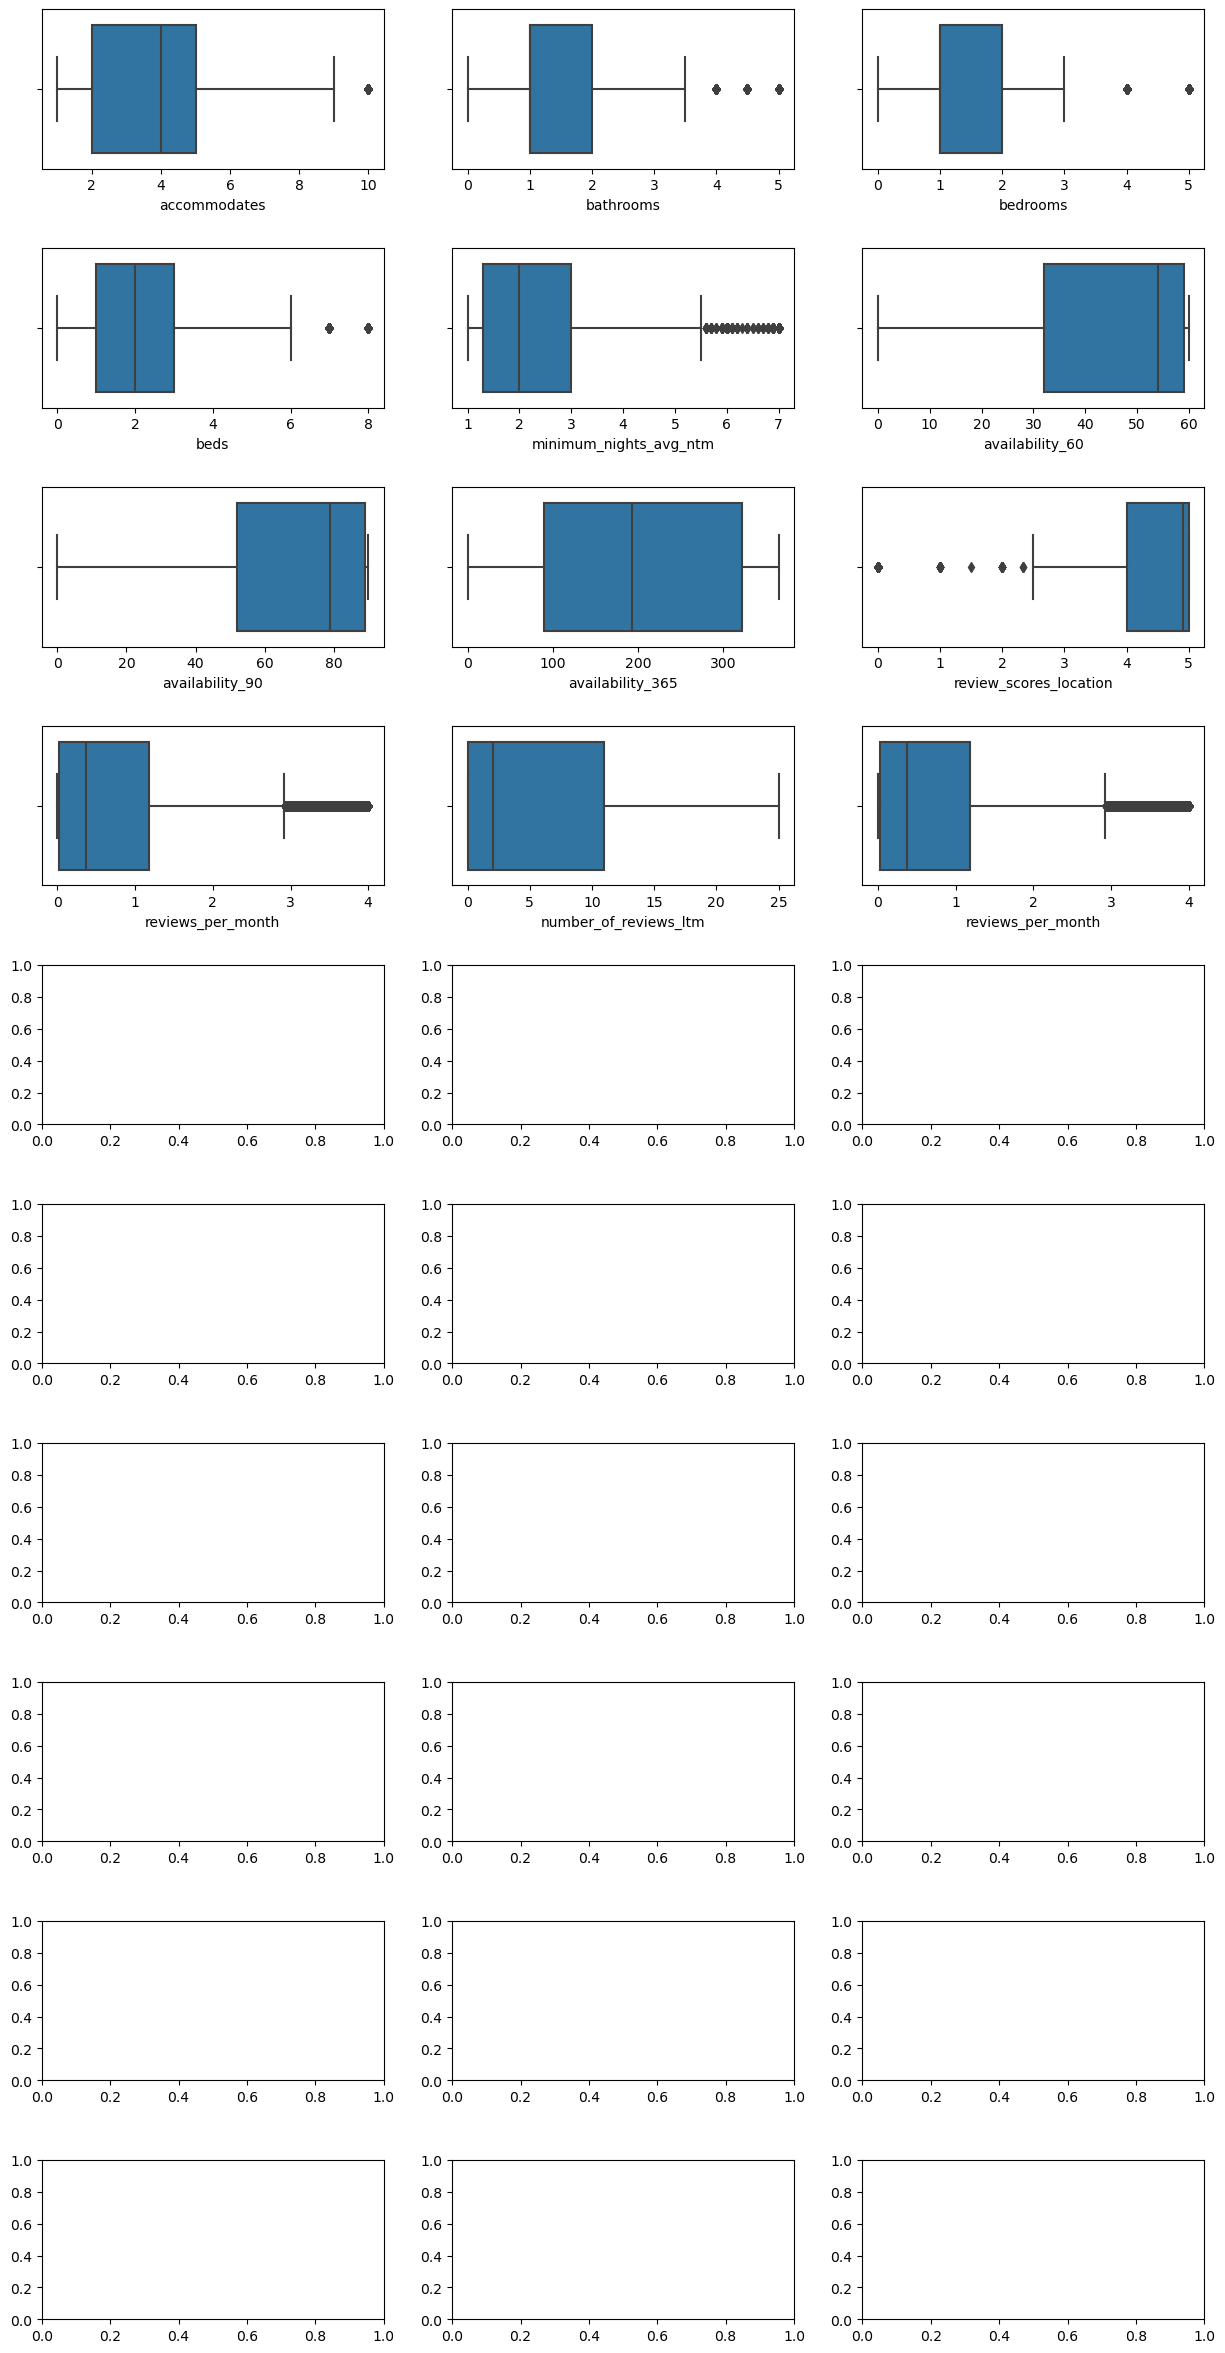

In [12]:
#Training
X_final = model_pipeline.fit_transform(X)

#Predict
#pred = model_pipeline.predict(X)

In [22]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size = 0.25, random_state = 70)


hgbr = HistGradientBoostingRegressor(random_state = 19,
                                            loss = "poisson",
                                            learning_rate = 0.05,
                                            max_features = 0.2,
                                            max_iter = 300,
                                            max_leaf_nodes= 81)



hgbr.fit(X_train, y_train)
y_pred = hgbr.predict(X_test)


# Calclulate the score for the following metrics
mae = mean_absolute_error(y_test, y_pred) #The lower the better
rmse = root_mean_squared_error(y_test, y_pred) #The lower the better
r2 = r2_score(y_test, y_pred) #Closer to 1 better
mape = mean_absolute_percentage_error(y_test, y_pred) #

In [62]:
results = [r2, mape, mae, rmse]

In [63]:
pd.DataFrame(results, index = ["r2", "mape", "mae", "rmse"])

,0
r2,0.652171
mape,0.354746
mae,107.614918
rmse,149.802247
